In [ ]:
from utils.binaries import *
from utils.plotting import *
from utils import CONSTANTS

In [ ]:
from scipy.optimize import curve_fit

set_plt_style('double tex')

def parabola(x, scale, mip, y0):
        return scale * (x - mip) ** 2 + y0

peak = np.loadtxt('peak.txt')
peak = peak[3::4, 5:]
start, stop = 7, 27

fit_params, error = curve_fit(parabola, CONSTANTS.UUB.SSD_PEAK[start:stop], peak[2][start:stop],
                              p0=[-0.01, 40, 1000])
asdasd = uncertainties.correlated_values(fit_params, error)

Y = parabola(CONSTANTS.UUB.SSD_PEAK, *fit_params)
ERR = tools.bootstrap_ci(parabola, fit_params, error, CONSTANTS.UUB.SSD_PEAK)

plt.plot(CONSTANTS.UUB.SSD_PEAK, peak[2])
plt.plot(CONSTANTS.UUB.SSD_PEAK, Y, c='k', ls='--', marker='none', lw=0.5,
         label=rf'$I^\mathrm{{SSD}}_\mathrm{{histo}} = {asdasd[1].n:.2f}\pm{asdasd[1].std_dev:.2f}\,\mathrm{{ADC}}$')
plt.fill_between(CONSTANTS.UUB.SSD_PEAK, ERR[0], ERR[1],
                 color='k', alpha=0.05,
                 edgecolor='none')

plt.xlabel('max. pulse height / ADC')
plt.ylabel('Occurences')

plt.xlim(0, 150)
plt.ylim(0, 1500)
plt.legend()

17:36:29 (   +3.0s) [INFO   ] -- import logging
17:36:29 (  +182ms) [INFO   ] -- import numpy as np
17:36:29 (   +12ms) [INFO   ] -- import uncertainties
17:36:29 (  +424ms) [INFO   ] -- import pandas as pd
17:36:29 (    +2ms) [WARNING] -- pandas support to be dropped at some point!
17:36:29 (    +2ms) [INFO   ] -- import binaries.tools as tools
17:36:30 (  +387ms) [INFO   ] -- import matplotlib.pyplot as plt
17:36:30 (  +527ms) [INFO   ] -- import seaborn as so
17:36:30 (    +2ms) [INFO   ] -- import plotting.tools as plot
17:36:30 (   +12ms) [DEBUG  ] -- font size set to 9.5
17:36:30 (    +1ms) [DEBUG  ] -- label size set to 13.0
17:36:30 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
17:36:30 (    +0ms) [DEBUG  ] -- markersize set to 2.0
17:36:30 (    +1ms) [DEBUG  ] -- usetex set to False
17:36:30 (   +23ms) [INFO   ] -- set MONI_PATH = '/cr/work/filip/monit_and_sd/'
17:36:30 (    +0ms) [INFO   ] -- set HIST_PATH = '/cr/work/filip/monit_and_sd/'
17:36:30 (    +1ms) [INFO   ]

(20095.439618055556, 20105.51733680556)

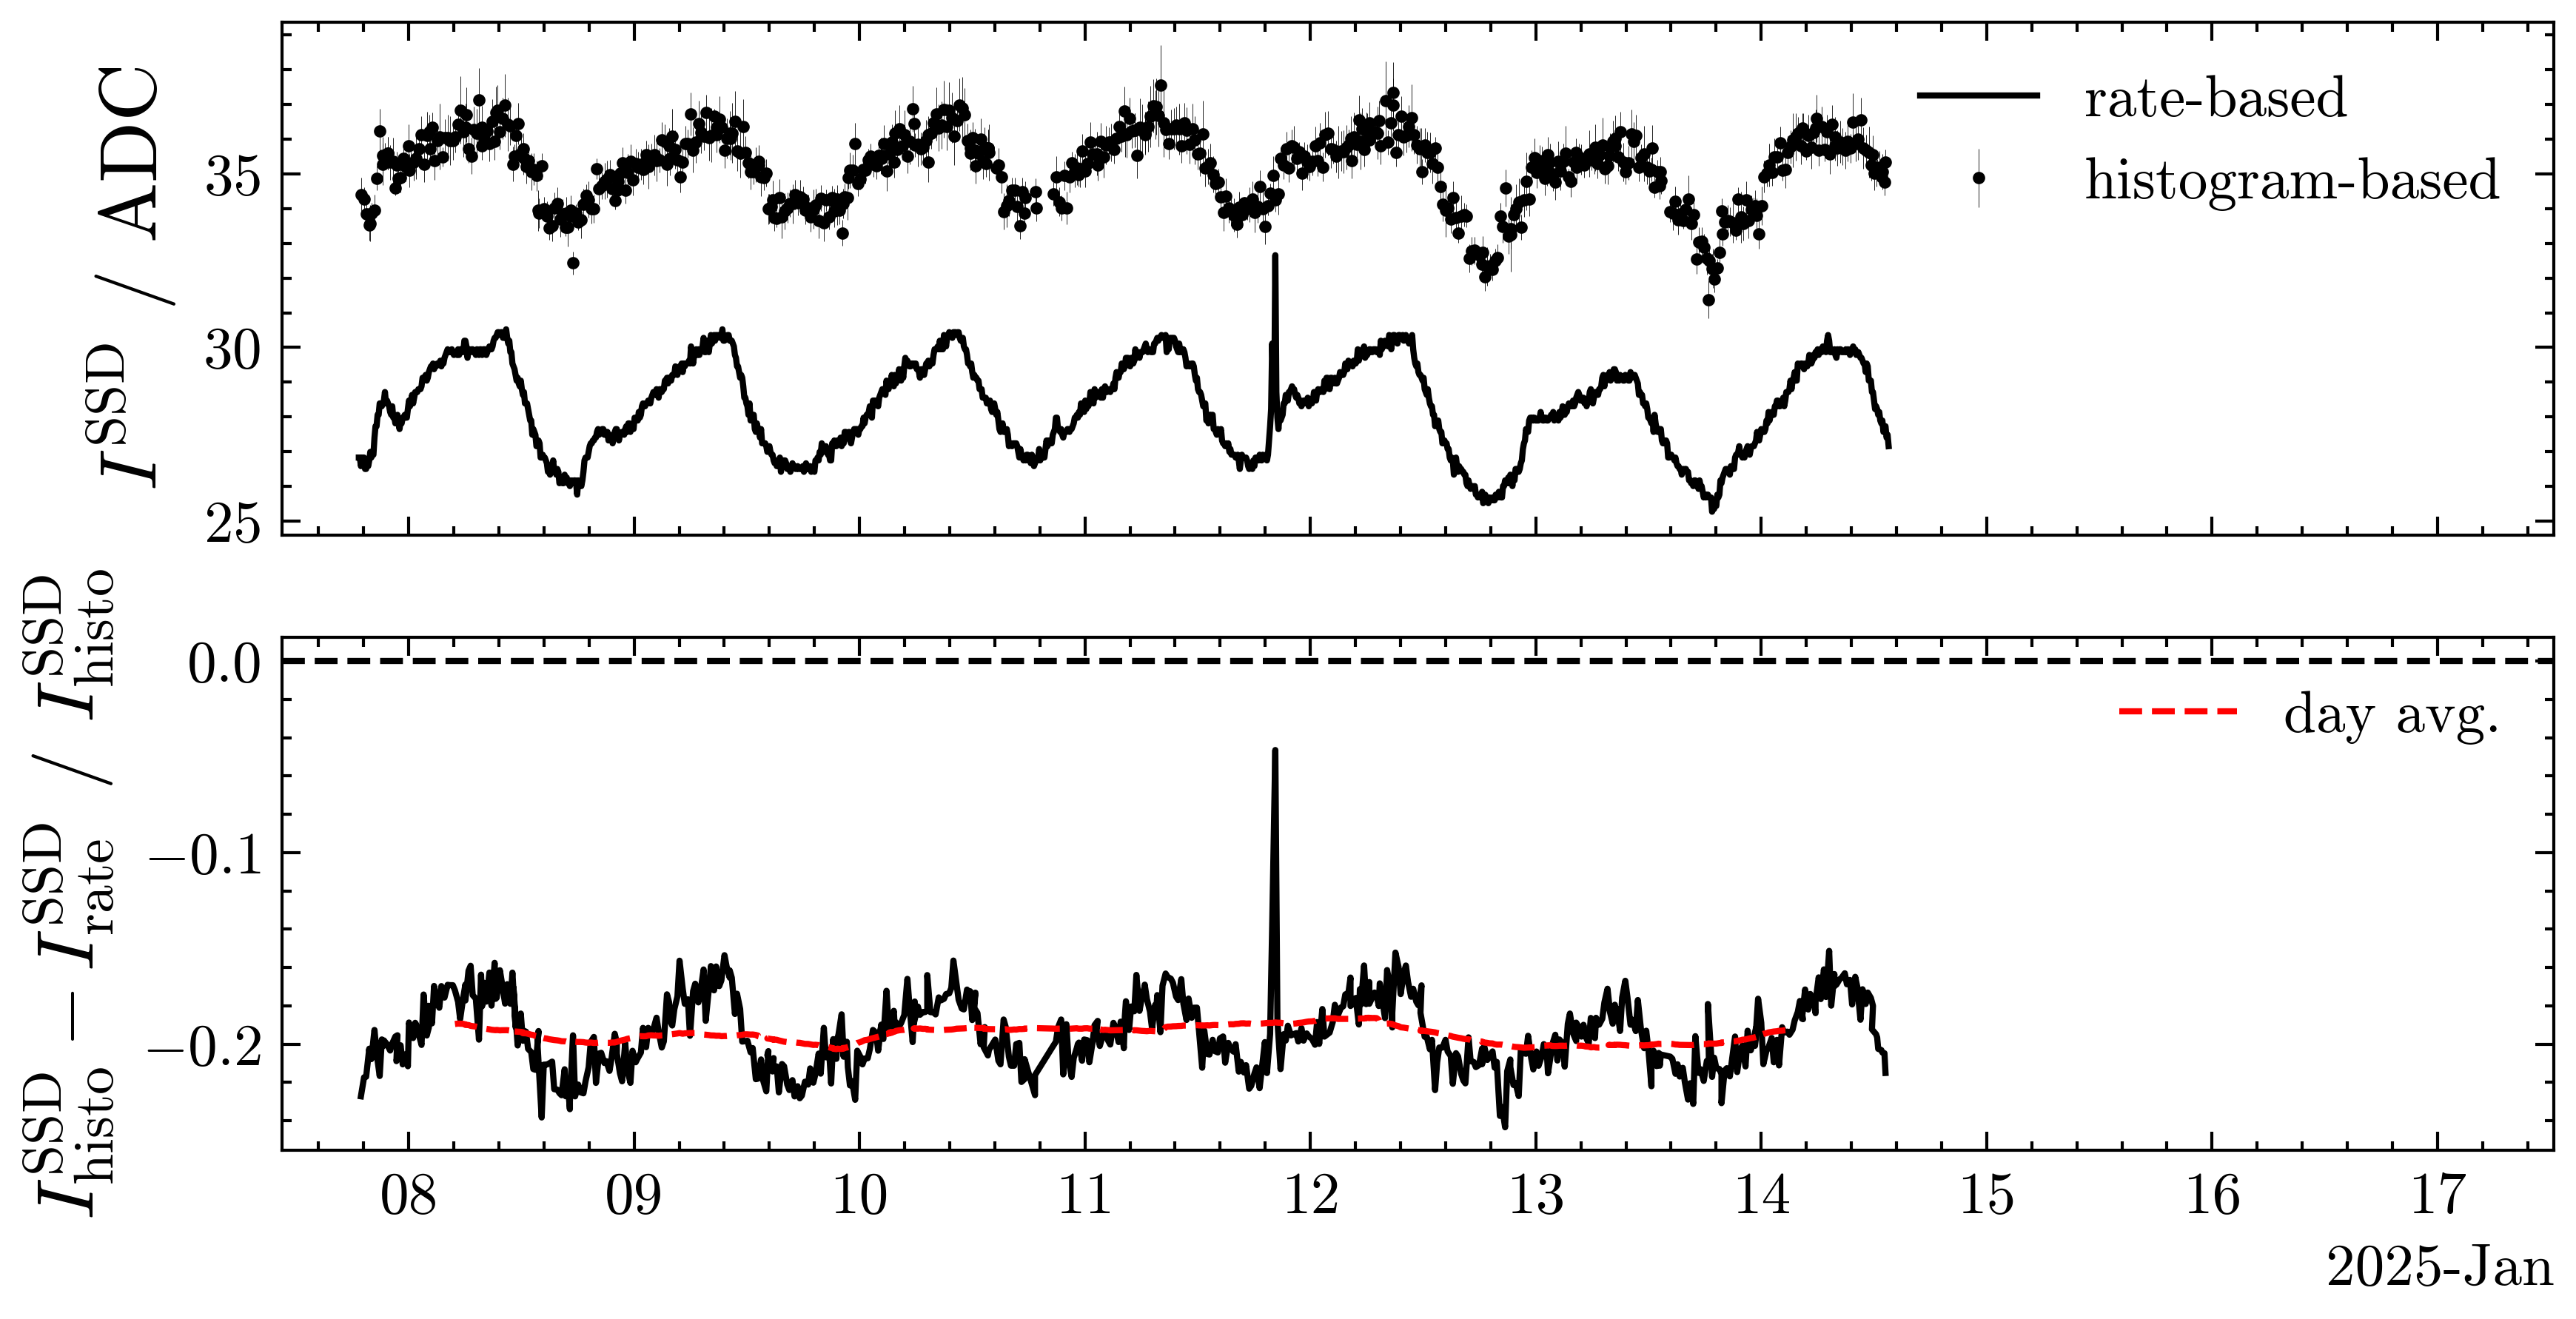

In [1]:
# import matplotlib.pyplot as plt
# import matplotlib.style
# from Histo import SdHisto
# from Monit import Monit
# import numpy as np
# import signal
# import matplotlib

from utils.binaries import *
from utils.plotting import *
from utils.Auger.SD import *
from datetime import datetime


# from matplotlib.colors import TABLEAU_COLORS
# from matplotlib import dates
# from datetime import datetime

# matplotlib.use('TkAgg')
# import scienceplots

# matplotlib.style.use(['science', 'ieee', 'no-latex'])


# reject 

from datetime import datetime

PROBLEM_START = datetime.strptime("Tue Jan 14 13:34:52 2025", "%a %b %d %H:%M:%S %Y").timestamp()
PROBLEM_STOP = datetime.strptime("Fri Jan 17 09:22:46 2025", "%a %b %d %H:%M:%S %Y").timestamp()

# Tue Jan 14 13:34:52 2025        # start of problems
# Fri Jan 17 09:22:46 2025        # end of problems

CORR_FACTOR = 1.21875
STATION = 944

to_dt = lambda ts: [datetime.fromtimestamp(t) for t in ts]

monit = Monit(2025, 1, range(7, 17))

# offline calib
histos = np.loadtxt('peak.txt')
histos = np.split(histos, len(histos)//4)

peak_times = {
        609: [],
        943: [],
        944: [],
        949: [],
        954: [],
        }

peak_values = {
        609: [],
        943: [],
        944: [],
        949: [],
        954: [],
        }

for i, histo in enumerate(histos):
    station_id = int(histo[:, 0][0])
    daq_time   = histo[:, 1][0]
    timestamp  = int(histo[:, 2][0])
    tube_mask  = histo[:, 3][0]
    iPMT = histo[:, 4]

    # if station_id in [945, 972, 948]: continue
    if station_id != STATION: continue

    PeakHisto = SdHisto(peak=histo[:, 5:], pmt_mask=[0,0,0,1])
    try:
        # print(f'{i:03} ping...', end='', flush=True)
        peak_charge = PeakHisto()
        # print('pong!')

        peak_times[station_id].append(timestamp)
        peak_values[station_id].append(peak_charge['peak'][-1])
        
        #fig = PeakHisto.plot()
        #fig.savefig(f"success/{station_id}_{timestamp}.png")
        #plt.clf()

    except KeyboardInterrupt:
        print('Thanks')
        fig = PeakHisto.plot()
        fig.savefig(f"fail/{station_id}_{timestamp}.png")
        plt.clf()
        continue

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# colors = iter(TABLEAU_COLORS)
colors = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])

diffs = {}
# online calib
for _id in [STATION]: #[609, 943, 944, 949, 954]: 

    c = next(colors)
    
    time = monit('fTime', _id)
    peak = monit('fPeak[4]', _id)
    peak = peak[:, -1] / CORR_FACTOR

    monit_time_mask = np.array([PROBLEM_START <= t <= PROBLEM_STOP for t in time])
    time = time[~monit_time_mask]
    peak = peak[~monit_time_mask]
    
    histo_time_mask = np.array([PROBLEM_START <= t <= PROBLEM_STOP for t in peak_times[_id]])
    nan_mask = ~np.isnan([x.n for x in peak_values[_id]])
    histo_mask = nan_mask & ~histo_time_mask

    peak_values[_id] = np.array(peak_values[_id])[histo_mask]
    peak_times[_id] = np.array(peak_times[_id])[histo_mask]

    ax1.plot(to_dt(time[1:]), peak[1:], marker='none', c=c, label='rate-based')
    ax1.errorbar(to_dt(peak_times[_id]), [x.n for x in peak_values[_id]], 
                 yerr=[x.std_dev for x in peak_values[_id]],
                 ls='none', fmt='o', markersize=1, c=c, lw=0.1, label='histogram-based')

    min_index = [np.argmin(np.abs(t - time)) for t in peak_times[_id]]
    diff = (peak[min_index] - np.array([x.n for x in peak_values[_id]])) / np.array([x.n for x in peak_values[_id]])

    # 1000s between events w/ running mean over 86 events = 23.89 hours
    ax2.plot(to_dt(time[min_index]), diff, marker='none', c=c)
    ax2.plot(to_dt(time[min_index])[43:-42], 
             np.convolve(diff, np.ones(86)/86, mode='valid'), label="day avg.", 
             marker='none')

    if _id == 609: continue

    diffs[_id] = diff

ax2.axhline(0, c='k', ls='--')
ax1.set_ylabel('$I^\mathrm{SSD}$ / ADC')
ax2.set_ylabel('$I^\mathrm{SSD}_\mathrm{histo} - I^\mathrm{SSD}_\mathrm{rate}$ / $I^\mathrm{SSD}_\mathrm{histo}$')
ax1.legend()
ax2.legend()

plot.apply_datetime_format(ax2)

xmin, xmax = ax2.get_xlim()
ax2.set_xlim(xmin, xmax + 0.35 * (xmax-xmin))

# fig.savefig('peaks_v3.png')


In [6]:
from datetime import date, timedelta
from datetime import datetime

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

def get_data(station, start_dt, end_dt):

    x1, y1, yerr1 = [], [], []
    x2, y2, yerr2 = [], [], []
    x3, y3, yerr3 = [], [], []

    path = '/cr/work/filip/weather_correlation'
    for d in daterange(start_dt, end_dt):
    
        temperature_measurements, pressure_measurements = 0, 0

        weather_AERAWS = np.loadtxt(f"{path}/AERAWS_{d.year:04}_{d.month:02}_{d.day:02}.dat")
        weather_CRS = np.loadtxt(f"{path}/CRS_{d.year:04}_{d.month:02}_{d.day:02}.dat")
        peaks = np.loadtxt(f"{path}/peaks_{d.year:04}_{d.month:02}_{d.day:02}.dat")

        for peak in peaks:
            if peak[0] != station: continue
            idx_AERAWS = tools.closest(weather_AERAWS[:, 0], peak[1], index=True)
            idx_CRS = tools.closest(weather_CRS[:, 0], peak[1], index=True)
            
            if np.isnan(peak[3]): continue
            if np.abs(peak[3]) > 0.4: continue

            if True:
                dd = datetime.fromtimestamp(peak[1])
                x3.append(dd.hour + dd.minute/60 + dd.second/3600)
                y3.append(peak[3])
                yerr3.append(peak[4])

            if np.abs(weather_AERAWS[idx_AERAWS, 0] - peak[1]) < 300:

                pressure_value_is_bogus = weather_AERAWS[idx_AERAWS, 1] < 600
                pressure_is_nan = np.isnan(weather_AERAWS[idx_AERAWS, 1])

                if not (pressure_value_is_bogus or pressure_is_nan):
                    x1.append(weather_AERAWS[idx_AERAWS, 1])
                    y1.append(peak[3])
                    yerr1.append(peak[4])
                    pressure_measurements += 1

            if np.abs(weather_CRS[idx_CRS, 0] - peak[1]) < 300:

                temperature_is_bogus = np.isnan(weather_CRS[idx_CRS, 1])

                if not (temperature_is_bogus or False):
                    x2.append(weather_CRS[idx_CRS, 2])
                    y2.append(peak[3])
                    yerr2.append(peak[4])
                    temperature_measurements += 1

        print(f"{d}: {temperature_measurements = }, {pressure_measurements = }")

    return x1, x2, x3, y1, y2, y3, yerr1, yerr2, yerr3

def make_plot(station, start_dt, end_dt):

    def ptp(x, y):

        indices = np.argsort(x)

        mean_start = np.mean(np.array(y)[indices][:10])
        mean_end = np.mean(np.array(y)[indices][-10:])


        return mean_start, mean_end, 100 * np.abs((mean_start - mean_end) / np.mean(y))

    x1, x2, x3, y1, y2, y3, yerr1, yerr2, yerr3 = get_data(station, start_dt, end_dt)

    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    # fig.suptitle(f"Station ID = {station}")
    fig, ax2 = plt.subplots()

    # i1, f1, ptp1 = ptp(x1, y1)
    # ax1.axhline(i1, xmax=0.1, c='r', label='low mean')
    # ax1.axhline(f1, xmin=0.9, c='b', label='high mean')
    # ax1.set_xlabel("pressure / hPa")
    # ax1.set_ylabel("$I^\mathrm{SSD}_\mathrm{rate} - I^\mathrm{SSD}_\mathrm{histo}$ / $I^\mathrm{SSD}_\mathrm{histo}$")
    # ax1.errorbar(x1, y1, yerr1, fmt='ko', lw=0.1)
    # ax1.text(
    #     0.04, 0.96, rf"$\rho$ = {np.corrcoef(x1, y1)[0, 1]:.2f}, $2\hat{{A}}$ = {ptp1:.2f}%",
    #     ha='left', va='center',
    #     transform=ax1.transAxes,
    # )

    i2, f2, ptp2 = ptp(x2, y2)
    ax2.axhline(i2, xmax=0.1, c='r', label='low mean', zorder=10)
    ax2.axhline(f2, xmin=0.9, c='b', label='high mean', zorder=10)
    ax2.set_xlabel("temperature / $^\circ$C")
    ax2.errorbar(x2, y2, yerr2, fmt='ko', lw=0.1)
    ax2.text(
        0.97, 0.94, rf"$\rho$ = {np.corrcoef(x2, y2)[0, 1]:.2f}", #, $2\hat{{A}}$ = {ptp2:.2f}%",
        ha='right', va='center',
        transform=ax2.transAxes,
    )

    ax2.set_ylabel('$I^\mathrm{SSD}_\mathrm{histo} - I^\mathrm{SSD}_\mathrm{rate}$ / $I^\mathrm{SSD}_\mathrm{histo}$')

    # i3, f3, ptp3 = ptp(x3, y3)
    # ax3.axhline(i3, xmax=0.1, c='r', label='low mean', zorder=10)
    # ax3.axhline(f3, xmin=0.9, c='b', label='high mean', zorder=10)
    # ax3.set_xlabel("time of day / h")
    # ax3.errorbar(x3, y3, yerr3, fmt='ko', lw=0.1)
    # ax3.text(
    #     0.04, 0.96, rf"$\rho$ = {np.corrcoef(x2, y2)[0, 1]:.2f}, $2\hat{{A}}$ = {ptp3:.2f}%",
    #     ha='left', va='center',
    #     transform=ax3.transAxes,
    # )

    # ax1.legend()
    # ax2.legend()
    # plt.subplots_adjust(wspace=0.04)

17:38:40 (  +46.3s) [DEBUG  ] -- font size set to 9.5
17:38:40 (    +1ms) [DEBUG  ] -- label size set to 13.0
17:38:40 (    +1ms) [DEBUG  ] -- figure size set to [2.2, 2.5]
17:38:40 (    +1ms) [DEBUG  ] -- markersize set to 2.0
17:38:40 (    +0ms) [DEBUG  ] -- usetex set to True


2025-01-07: temperature_measurements = 22, pressure_measurements = 0
2025-01-08: temperature_measurements = 98, pressure_measurements = 21
2025-01-09: temperature_measurements = 96, pressure_measurements = 24
2025-01-10: temperature_measurements = 88, pressure_measurements = 19
2025-01-11: temperature_measurements = 92, pressure_measurements = 20
2025-01-12: temperature_measurements = 93, pressure_measurements = 23
2025-01-13: temperature_measurements = 95, pressure_measurements = 25
2025-01-14: temperature_measurements = 28, pressure_measurements = 0


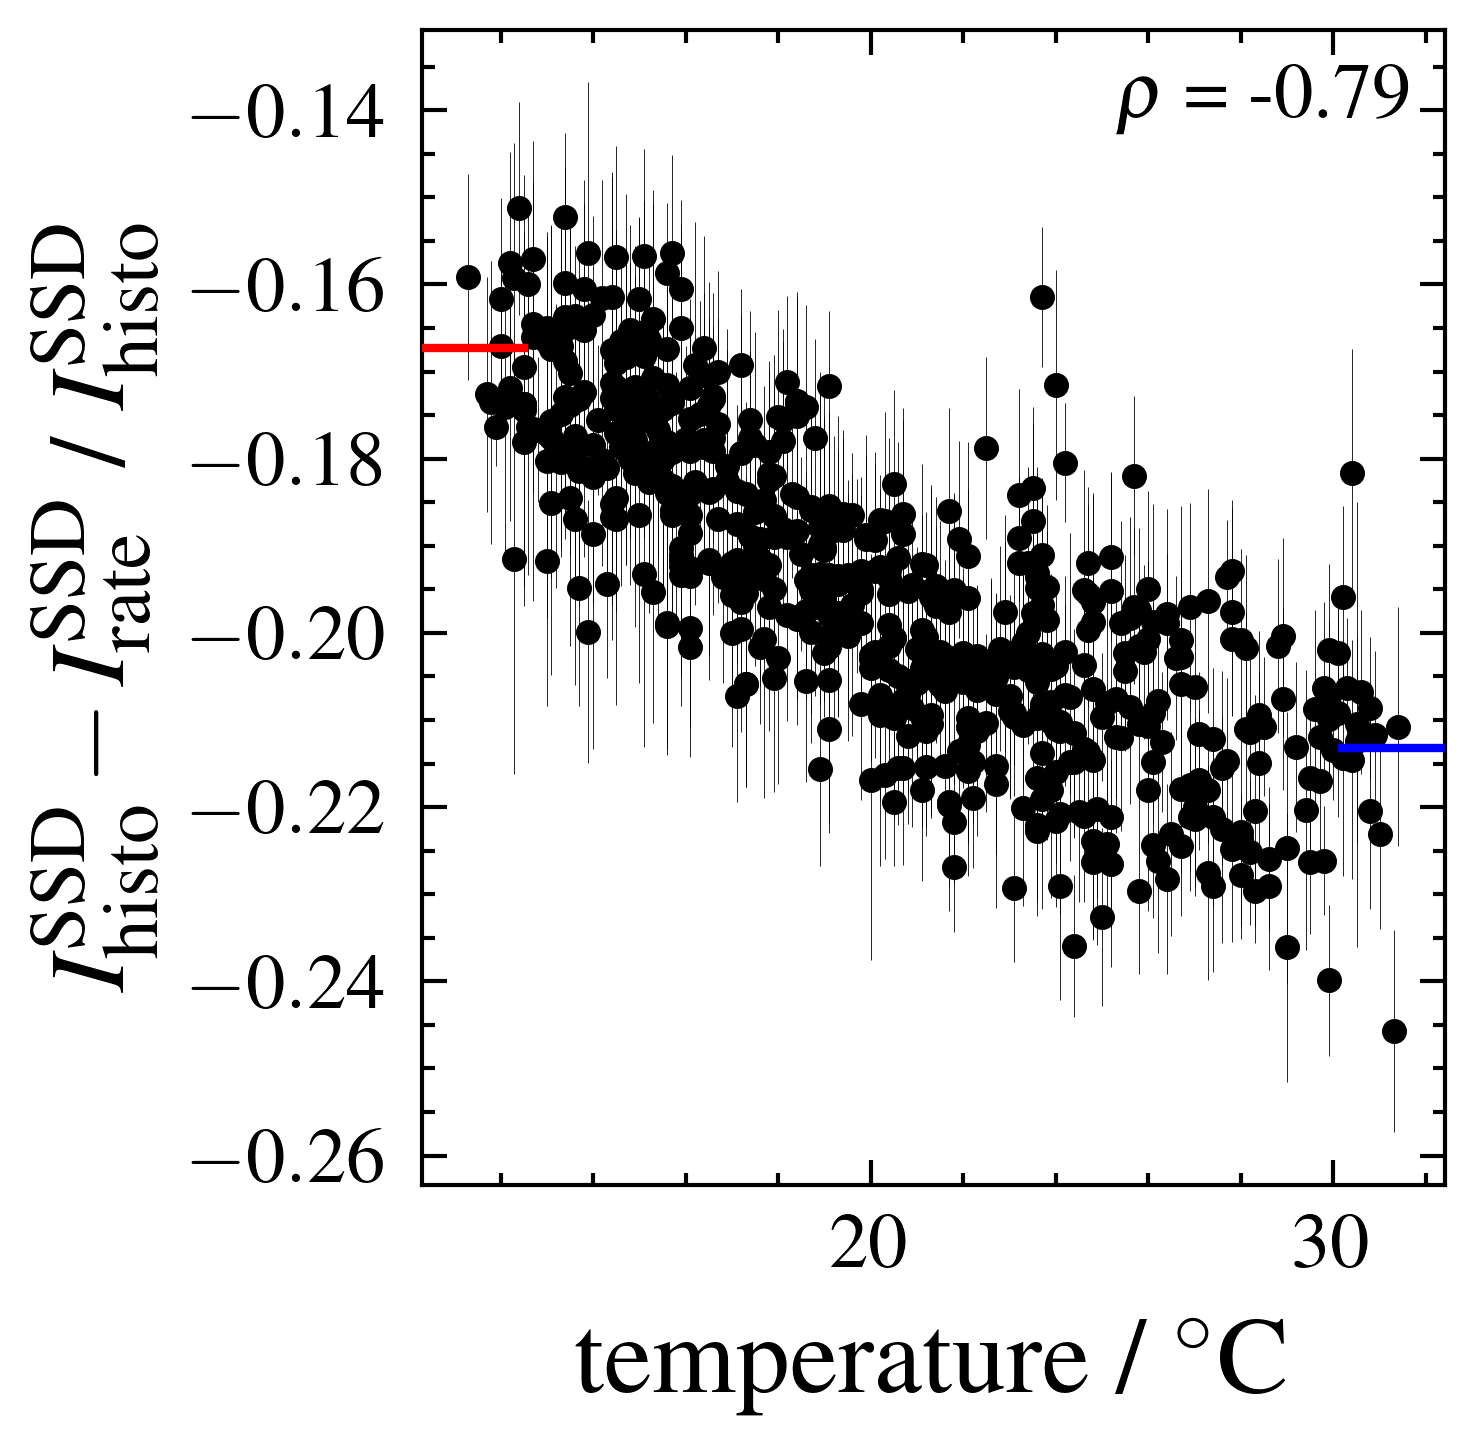

In [7]:
START = date(2025, 1, 7)
STOP = date(2025, 1, 14)

set_plt_style('tex triple')
make_plot(944, START, STOP)